# Ejercicio Ridge, Lasso y ElasticNet
Para este ejercicio vas a trabajar con datos de ventas de una empresa que fabrica muebles en España. Esta empresa es una Pyme que demanda conocer de antemano qué ingresos va a tener cada mes, ya que necesita pedir un anticipio a su entidad financiera de cara a poder abastecerse de materia prima al comenzar el mes. Como desconoce cuánto tiene que pedir, tira al alza y acaba pagando muchos intereses. El objetivo es reducir estos gastos.

En las bases de datos de la empresa constan todos los gastos en publicidad y ventas, para cada uno de los meses desde su fundación (hace más de 15 años).

Dado que los presupuestos de marketing se cierran al principio de cada mes, la empresa necesita un modelo predictivo que le anticipe las ventas que conseguirá a final de mes en función de los gastos que realizará en marketing.

Para ello tendrás que utilizar tanto modelos de regresión normales, como regularizados.

1. Carga los datos y realiza un pequeño análisis exploratorio. Mira a ver cómo se relaciona las ventas con el resto de variables.
2. Crea varios modelos y modifica los hiperparámetros necesarios para mejorar el performance del modelo.
3. Interpreta los resultados. Traduce a una fórmula tu mejor modelo (escribir la fórmula simplemente). ¿Cuánto cambian las ventas si aumentamos la inversión en radio un punto más? ¿Y si aumentamos la inversión en TV o periódicos?

## Import libraries 

In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler


In [3]:
def metricas(X_train, X_test, y_train, y_test, predict, regresion):
  print("Train MSE:", metrics.mean_squared_error(y_train, regresion.predict(X_train)))
  print("Test MSE:", metrics.mean_squared_error(y_test, regresion.predict(X_test)))
  print("Test MAE:", metrics.mean_absolute_error(y_test, predict))
  print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, regresion.predict(X_test))))
  print("Test MAPE:", metrics.mean_absolute_percentage_error(y_test, predict))
  print("R2Score: ", metrics.r2_score(y_test, predict))
  print(regresion.score(X_train, y_train))
  print(regresion.score(X_test, y_test))

## Exploratory Data Analysis 

In [4]:
df = pd.read_csv("./data/Advertising.csv", index_col=0)
df

,TV,radio,newpaper,sales
0,230.1,37.8,6s9.2,22100.0
1,44.5,39.3,45.1,10400.0
2,17.2,45.9,69.3,9300.0
3,151.5,41.3,58.5,18500.0
4,180.8,10.8,58.4,12900.0
...,...,...,...,...
195,38.2,3.7,13.8,7600.0
196,94.2,4.9,8.1,9700.0
197,177.0,9.3,6.4,12800.0
198,283.6,42.0,66.2,25500.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   TV        200 non-null    float64
 1   radio     200 non-null    float64
 2   newpaper  200 non-null    object 
 3   sales     200 non-null    float64
dtypes: float64(3), object(1)
memory usage: 7.8+ KB


hay un error en el csv. Hay un dato con una S

In [6]:
df['newpaper'] = (
    df['newpaper']
    .str.replace('s', '', regex=False)
    .str.replace(',', '.', regex=False) 
    .astype(float)
)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   TV        200 non-null    float64
 1   radio     200 non-null    float64
 2   newpaper  200 non-null    float64
 3   sales     200 non-null    float64
dtypes: float64(4)
memory usage: 7.8 KB


Ahora todo son floats

In [8]:
df.describe()

,TV,radio,newpaper,sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14022.500000
std,85.854236,14.846809,21.778621,5217.456566
min,0.700000,0.000000,0.300000,1600.000000
25%,74.375000,9.975000,12.750000,10375.000000
50%,149.750000,22.900000,25.750000,12900.000000
75%,218.825000,36.525000,45.100000,17400.000000
max,296.400000,49.600000,114.000000,27000.000000


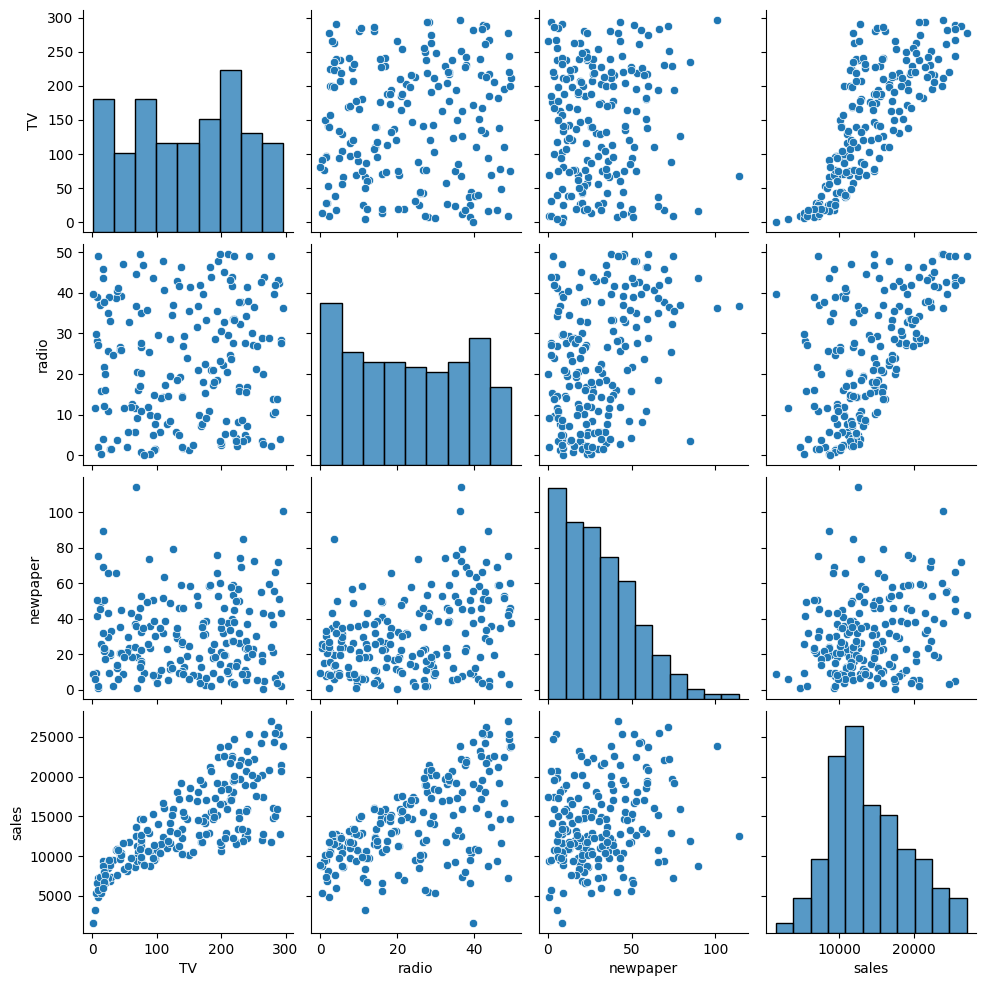

In [9]:
sns.pairplot(df);

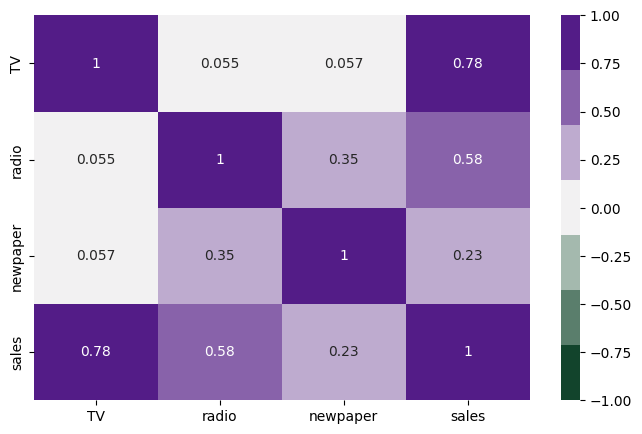

In [10]:
plt.figure(figsize=(8,5))
sns.heatmap(df.corr(),
           vmin=-1,
           vmax=1,
           cmap=sns.diverging_palette(145, 280, s=85, l=25, n=7),
           annot=True);

## Modelado

In [11]:
X = df[["newpaper", "radio", "TV"]]
X

,newpaper,radio,TV
0,69.2,37.8,230.1
1,45.1,39.3,44.5
2,69.3,45.9,17.2
3,58.5,41.3,151.5
4,58.4,10.8,180.8
...,...,...,...
195,13.8,3.7,38.2
196,8.1,4.9,94.2
197,6.4,9.3,177.0
198,66.2,42.0,283.6


In [12]:
y = df["sales"]
y

0      22100.0
1      10400.0
2       9300.0
3      18500.0
4      12900.0
        ...   
195     7600.0
196     9700.0
197    12800.0
198    25500.0
199    13400.0
Name: sales, Length: 200, dtype: float64

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [14]:
print("Total features shape:", X.shape)
print("Train features shape:", X_train.shape)
print("Train target shape:", y_train.shape)
print("Test features shape:", X_test.shape)
print("Test target shape:", y_test.shape)

Total features shape: (200, 3)
Train features shape: (160, 3)
Train target shape: (160,)
Test features shape: (40, 3)
Test target shape: (40,)


In [15]:
#regresion lineal
lr1 = LinearRegression()

lr1.fit(X_train, y_train)

y_pred = lr1.predict(X_test)
baseline_error = metrics.mean_squared_error(y_test, y_pred)

metricas(X_train, X_test, y_train, y_test, y_pred, lr1 )

Train MSE: 2705129.4230814143
Test MSE: 3174097.3539761016
Test MAE: 1460.7567168117598
Test RMSE: 1781.5996615334495
Test MAPE: 0.15198846602831223
R2Score:  0.8994380241009121
0.8957008271017817
0.8994380241009121


In [16]:
#regresion polinomica grado 2

poly_feats = PolynomialFeatures(degree = 2)
poly_feats.fit(X_train)
X_train_poly = poly_feats.transform(X_train)  
X_test_poly = poly_feats.transform(X_test)  

lr = LinearRegression()
lr.fit(X_train_poly, y_train)

y_pred_pol2 = lr.predict(X_test_poly)

metricas(X_train_poly, X_test_poly, y_train, y_test, y_pred_pol2, lr )

Train MSE: 360396.6744701223
Test MSE: 412910.2285378992
Test MAE: 526.1794444043735
Test RMSE: 642.5809120553607
Test MAPE: 0.04893877124817151
R2Score:  0.9869181490609605
0.986104518792419
0.9869181490609605


In [17]:
#regresion polinomica grado 3

poly_feats = PolynomialFeatures(degree = 3)
poly_feats.fit(X_train)
X_train_poly = poly_feats.transform(X_train)  
X_test_poly = poly_feats.transform(X_test)  

lr = LinearRegression()
lr.fit(X_train_poly, y_train)

y_pred_pol3 = lr.predict(X_test_poly)

metricas(X_train_poly, X_test_poly, y_train, y_test, y_pred_pol3, lr )

Train MSE: 216061.16397546837
Test MSE: 294568.40911128407
Test MAE: 388.681704881308
Test RMSE: 542.7415675174365
Test MAPE: 0.03524411219609336
R2Score:  0.9906674629180562
0.9916695295589968
0.9906674629180562


## NORMALIZACIÓN

In [18]:
scaler = StandardScaler()
scaler.fit(X_train)

,copy,True
,with_mean,True
,with_std,True


In [19]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
#Ridge

n_alphas = 100
alphas = np.logspace(-3, 4, n_alphas) 

coef_ridge = []
err_ridge = []
baseline = []

for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train_scaled, y_train)
    
    coef_ridge.append(ridge.coef_)
    
    y_pred = ridge.predict(X_test_scaled)
    ridge_error = metrics.mean_squared_error(y_pred, y_test)
    
    err_ridge.append(ridge_error)
    baseline.append(baseline_error)

In [21]:
min(err_ridge)

3174116.624396939

In [22]:
np.array(err_ridge).argmin()

np.int64(0)

In [23]:
alphas[np.array(err_ridge).argmin()]

np.float64(0.001)

<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Sergio\AppData\Local\Temp\ipykernel_11616\1187573374.py:6: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$', fontsize=20)


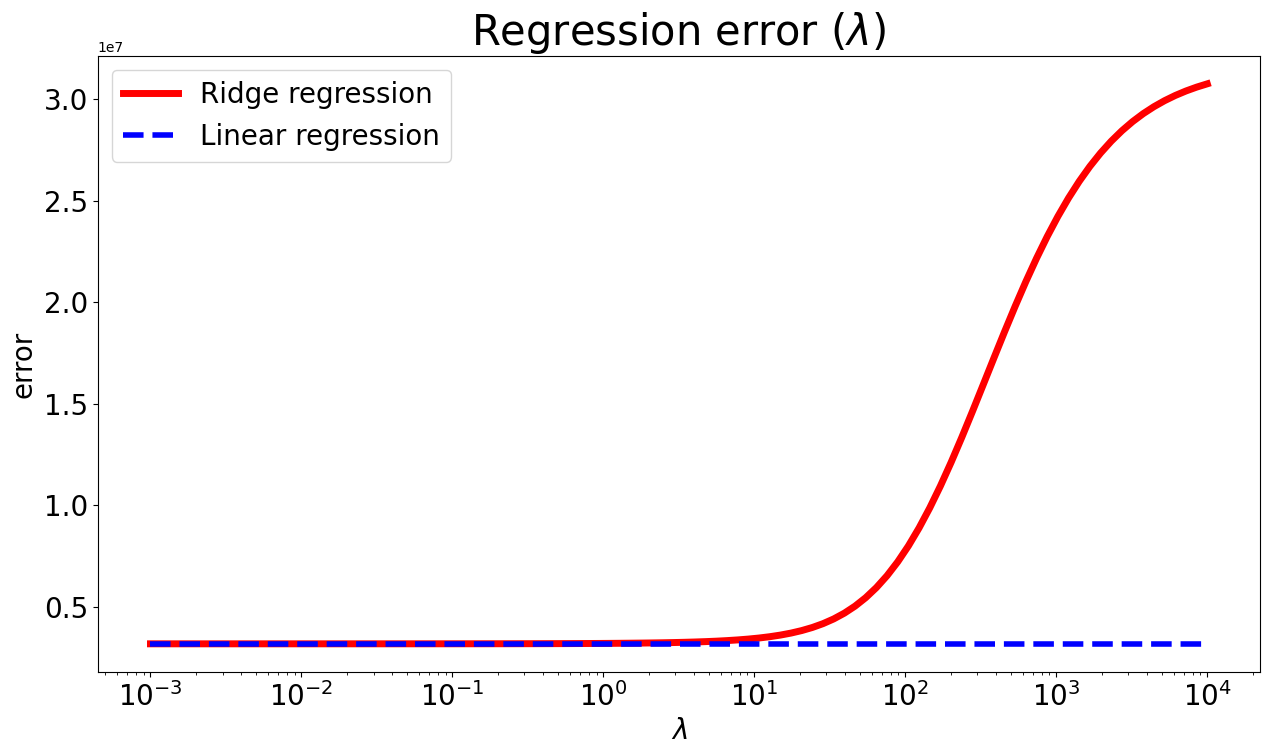

In [24]:
plt.figure(figsize=(15,8))
ax = plt.gca()
ax.plot(alphas, err_ridge, linewidth=5, color='red', label="Ridge regression")
ax.plot(alphas, baseline, linewidth=4,linestyle='--', color='blue', label='Linear regression')
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('error', fontsize=20)
ax.legend(fontsize=20)
plt.title(r'Regression error ($\lambda$)', fontsize=30)
plt.show()

In [25]:
from sklearn.linear_model import Ridge 
  
# Train the model  
ridgeR = Ridge(alpha = 0.001) 
ridgeR.fit(X_train_scaled, y_train) 
predict_ridge = ridgeR.predict(X_test_scaled)

metricas(X_train_scaled, X_test_scaled, y_train, y_test, predict_ridge, ridgeR)

Train MSE: 2705129.4239455312
Test MSE: 3174116.624396939
Test MAE: 1460.760302110617
Test RMSE: 1781.6050697045457
Test MAPE: 0.15198848757133102
R2Score:  0.899437413574082
0.8957008270684648
0.899437413574082


<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Sergio\AppData\Local\Temp\ipykernel_11616\2393052791.py:5: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$', fontsize=30)


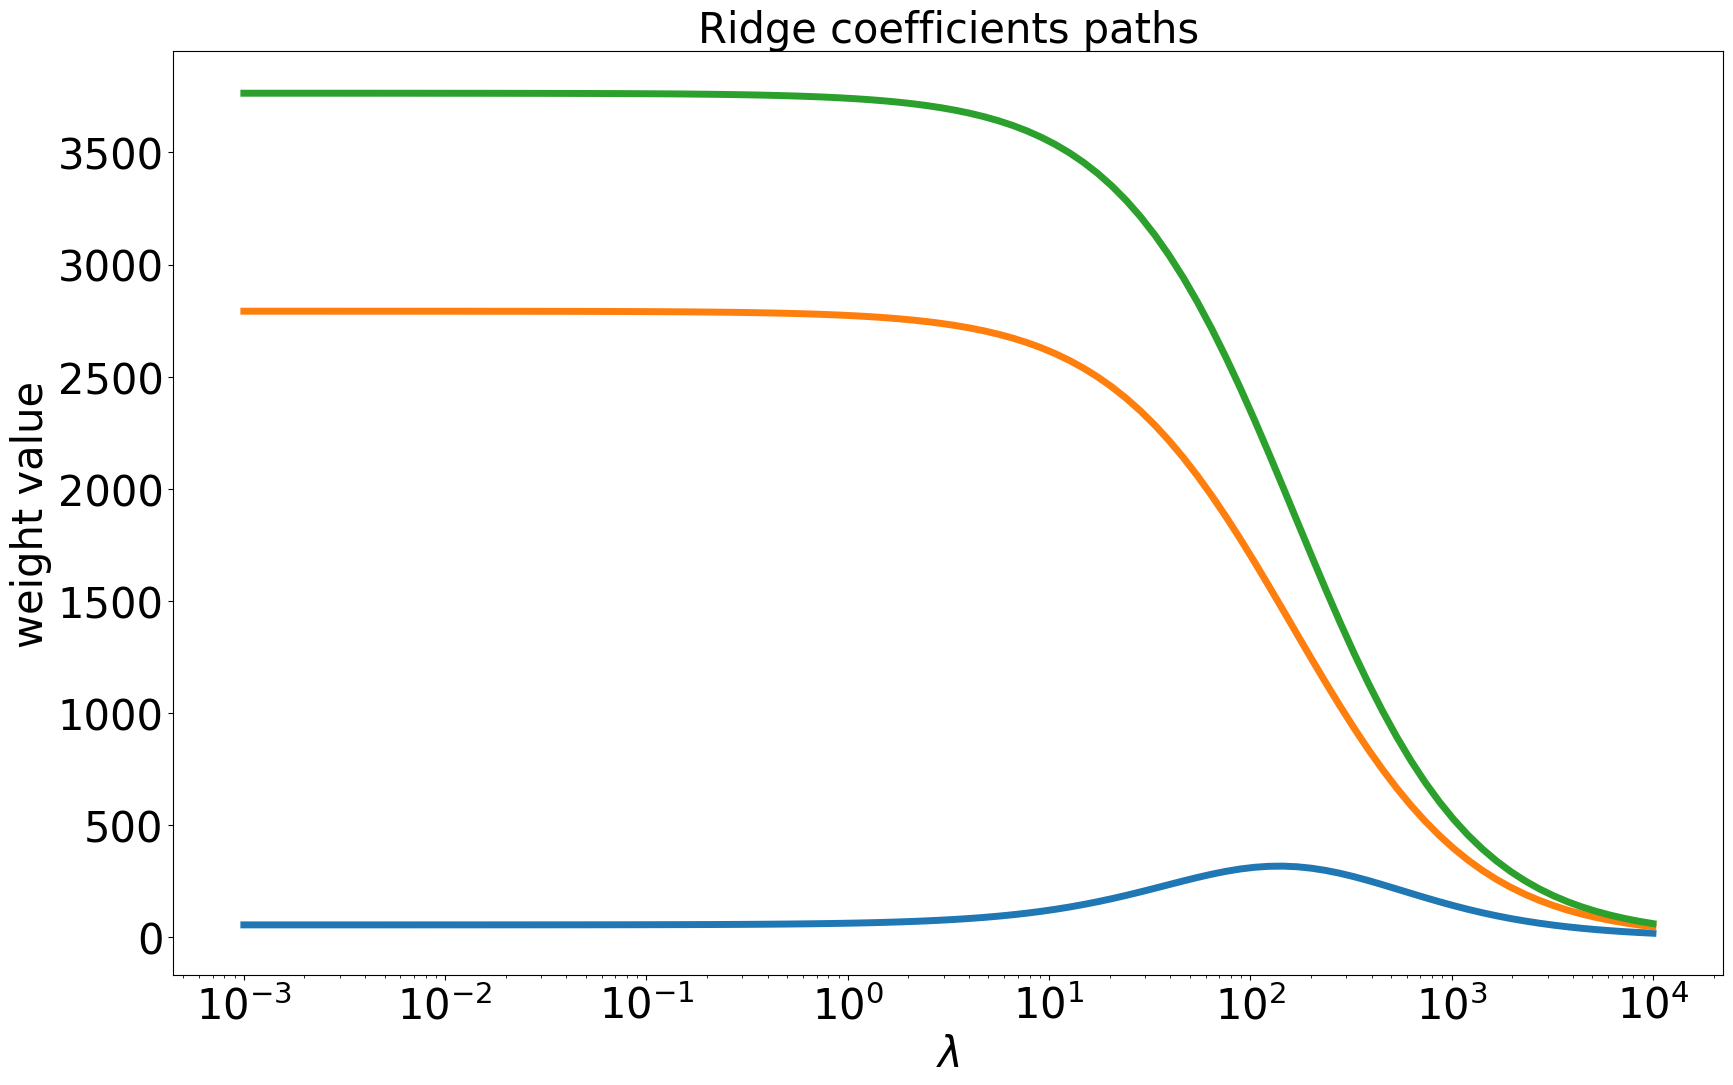

In [26]:
plt.figure(figsize=(20,12))
ax = plt.gca()
ax.plot(alphas, coef_ridge, linewidth=5)
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('weight value', fontsize=30)
plt.title('Ridge coefficients paths', fontsize=30)
plt.show()

In [27]:
#lasso

lasso = Lasso(fit_intercept=True)

coef_lasso = []
err_lasso = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train_scaled, y_train)
    coef_lasso.append(lasso.coef_)
    y_pred = lasso.predict(X_test_scaled)
    lasso_error = metrics.mean_squared_error(y_pred, y_test)    
    err_lasso.append(lasso_error)

In [28]:
min(err_lasso)

3173929.2657990903

In [29]:
np.array(err_lasso).argmin()

np.int64(55)

In [30]:
alphas[np.array(err_lasso).argmin()]

np.float64(7.742636826811269)

<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Sergio\AppData\Local\Temp\ipykernel_11616\622328189.py:6: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$', fontsize=30)


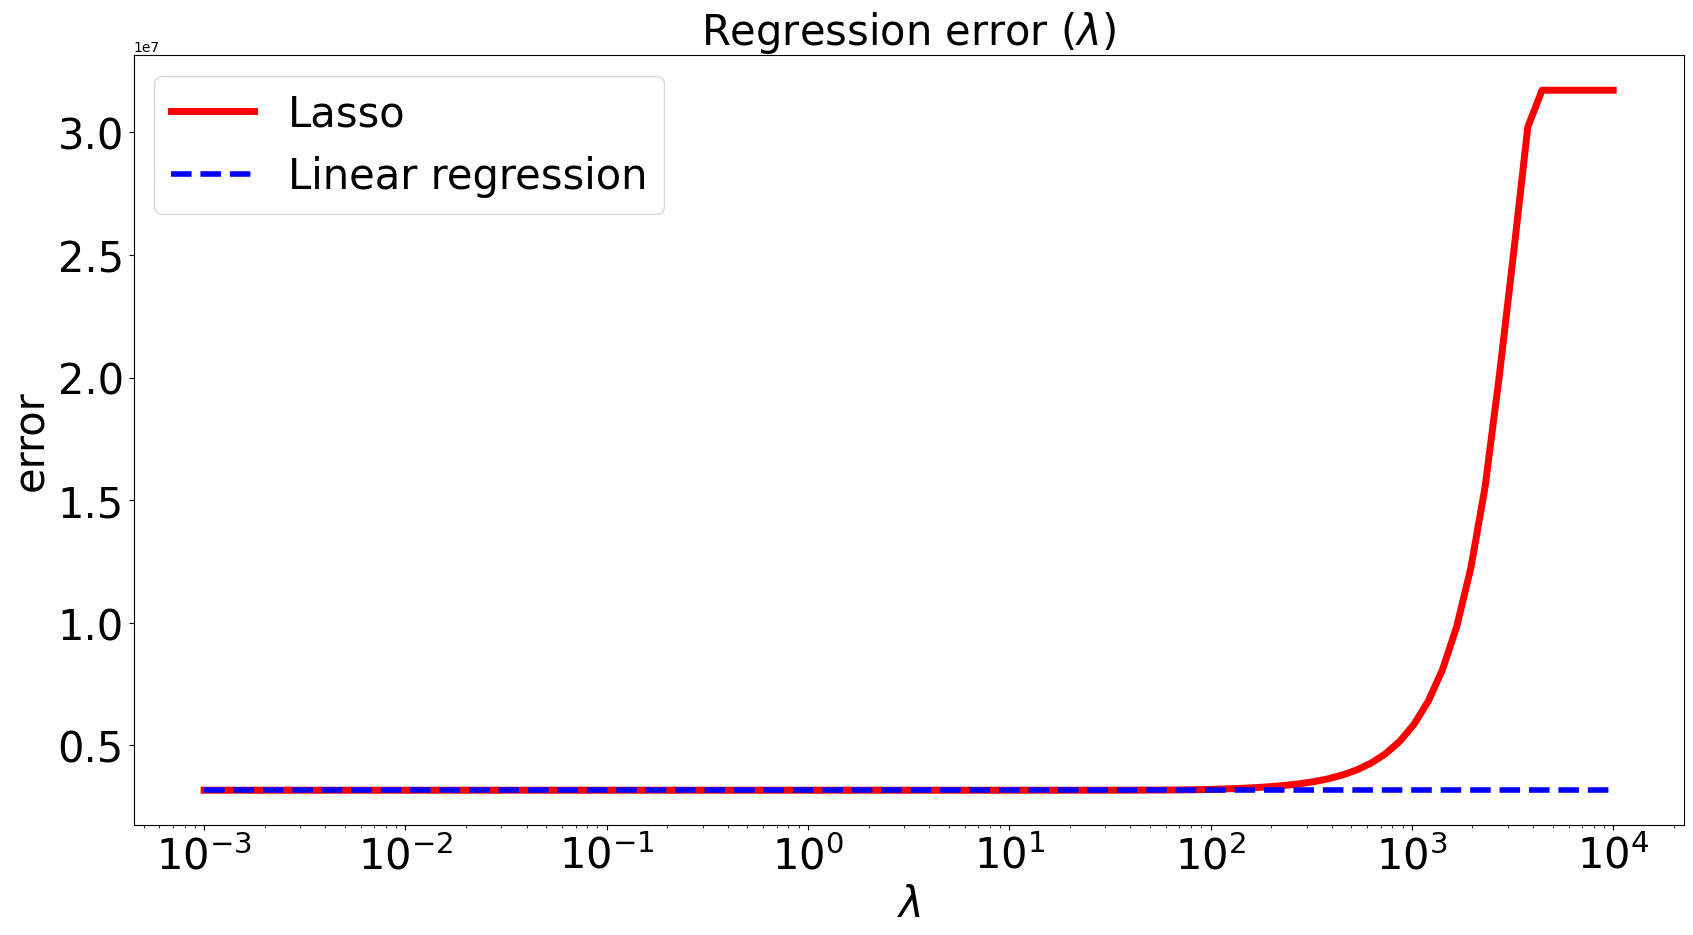

In [31]:
plt.figure(figsize=(20,10))
ax = plt.gca()
ax.plot(alphas, err_lasso, linewidth=5, color='red', label="Lasso")
ax.plot(alphas, baseline, linewidth=4,linestyle='--', color='blue', label='Linear regression')
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('error', fontsize=30)
ax.legend(fontsize=30)
plt.title(r'Regression error ($\lambda$)', fontsize=30)
plt.show()

In [32]:
lassoR = Lasso(alpha = 8) 
lassoR.fit(X_train_scaled, y_train) 

predict_lasso = lassoR.predict(X_test_scaled)
metricas(X_train_scaled, X_test_scaled, y_train, y_test, predict_lasso, lassoR)

Train MSE: 2705278.7790708877
Test MSE: 3173929.024352261
Test MAE: 1459.3343503027577
Test RMSE: 1781.5524197598736
Test MAPE: 0.15177780007836872
R2Score:  0.8994433571319089
0.8956950685210512
0.8994433571319089


<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Sergio\AppData\Local\Temp\ipykernel_11616\2245268358.py:5: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$', fontsize=30)


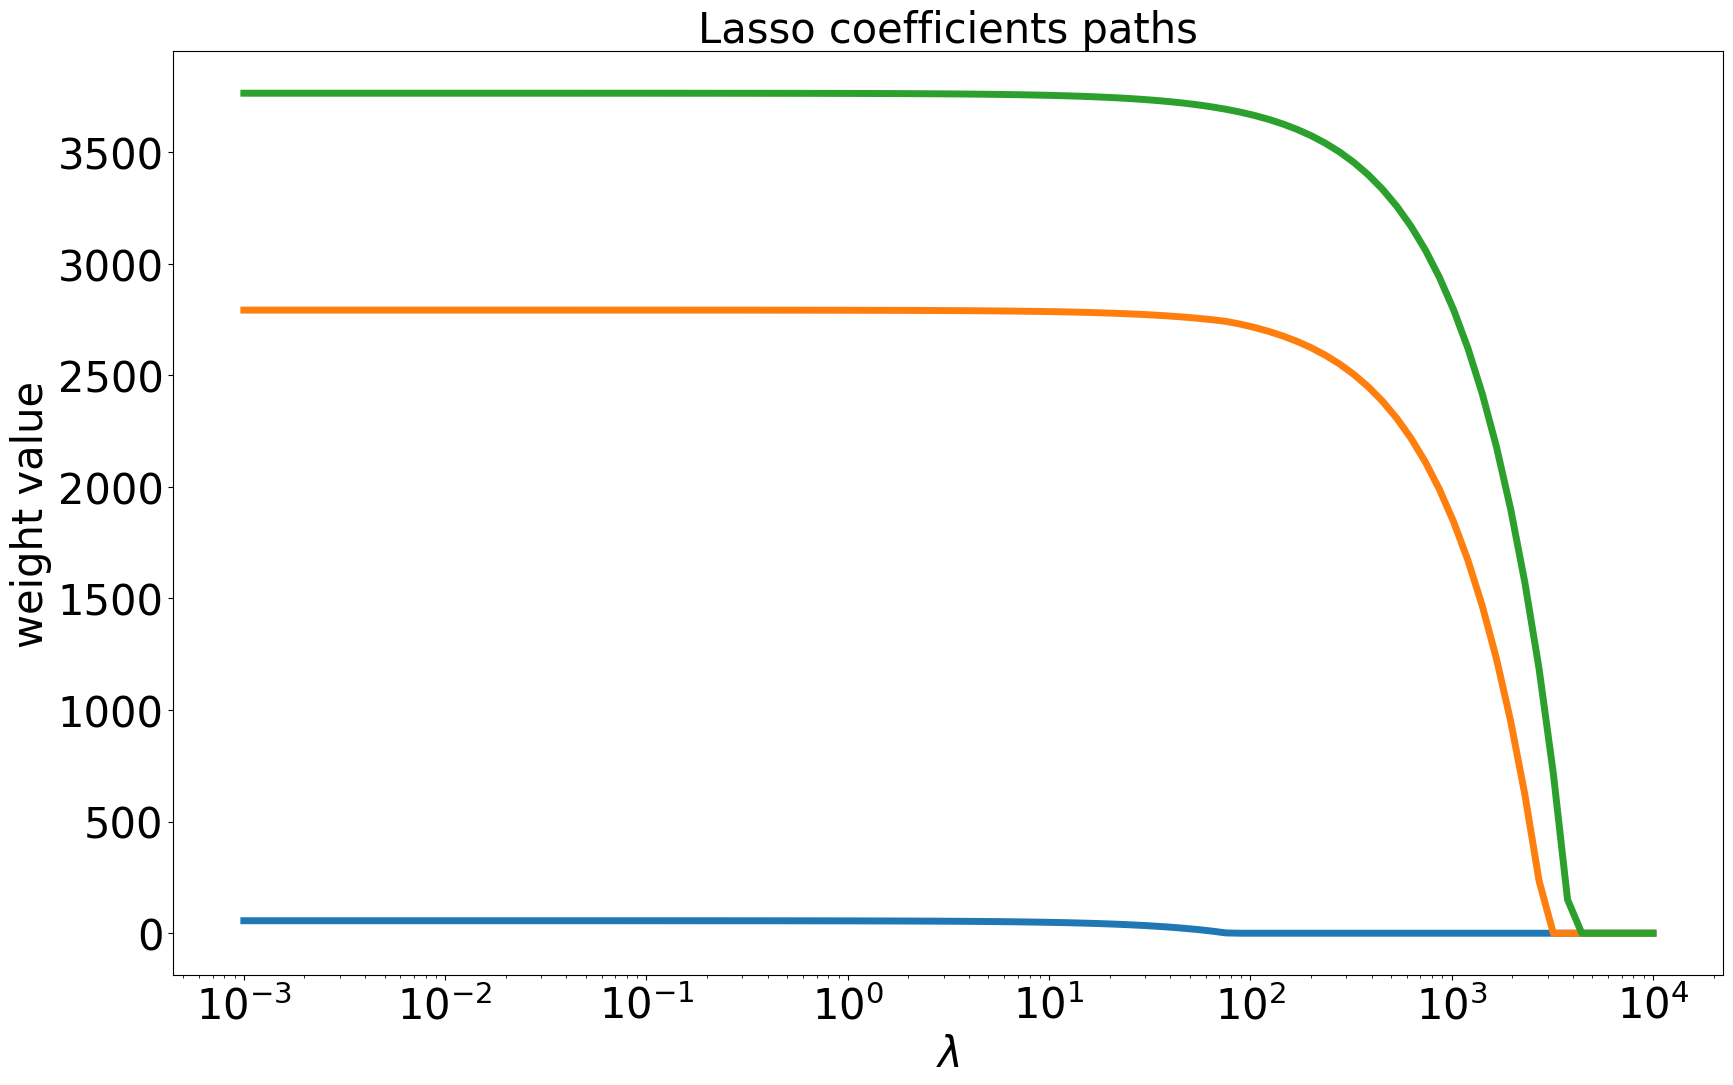

In [33]:
plt.figure(figsize=(20,12))
ax = plt.gca()
ax.plot(alphas, coef_lasso, linewidth=5)
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('weight value', fontsize=30)
plt.title('Lasso coefficients paths', fontsize=30)
plt.show()

In [34]:
#el modelo que se ajusta mejor es el linear
print(lr1.coef_)
print(lr1.intercept_)

[  2.76111434 189.19505423  44.72951747]
2979.067338122628


sales = 2979.0673 + 2.7611 * TV + 189.1951 * radio +44.7295 * newspaper